# Projet Apprentissage Profond

## 1. Chargement des données

In [23]:
!git clone https://github.com/Spiroxx/projet_ap.git

Cloning into 'projet_ap'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 195 (delta 2), reused 3 (delta 1), pack-reused 188 (from 1)
Receiving objects: 100% (195/195), 61.05 MiB | 20.65 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [39]:
import PIL
from PIL import Image
import csv
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

## Préparation des données

Le code ci-dessous permet de charger les données et les formater pour la classification. Prenez le temps de regarder un peu le format des labels $y$.
Notez que les images sont rendues carrées lors du chargement.

In [28]:
# Lecture du CSV contenant les informations relatives à la base de données
dataset = []
with open('projet_ap/data.csv', newline='') as csvfile:
	filereader = csv.reader(csvfile, delimiter=' ', quotechar='|')
	for row in filereader:
		data = row[0].split(',')
		if data[0] != 'DATA' and  data[0] != 'TEST':
			box = [float(data[4]), float(data[5]), float(data[6]), float(data[7])]
			new_entry = {'type': data[0], 'path': data[1], 'shape': [float(data[2]), float(data[3])], 'box': box}
			dataset.append(new_entry)

# Nombre de classes de la base de données et intitulé des classes
#class_labels = list(dict.fromkeys([item['specie'] for item in dataset]))
#num_classes = len(class_labels)

# Extraction des données d'apprentissage et de test
dataset_train = [item for item in dataset if item['type']=='TRAIN']
dataset_test = [item for item in dataset if item['type']=='TEST']

#print(class_labels)

In [47]:
def build_localization_tensors(image_size, dataset, num_classes):
  # Préparation des structures de données pour x et y
  x = np.zeros((len(dataset), image_size, image_size, 3))
  y = np.empty((len(dataset), num_classes + 5)) # 1 + 4 + num_classes : présence / boîte englobante / classes

  # Compteur de parcours du dataset
  i = 0

  for item in dataset:
    # Lecture de l'image
    img = Image.open('projet_ap/' + item['path'])
    # Mise à l'échelle de l'image
    img = img.resize((image_size,image_size), Image.Resampling.LANCZOS)
    # Remplissage de la variable x
    x[i] = np.asarray(img)

    y[i, 0] = 1 # Un objet est toujours présent !

    # Coordonnées de boîte englobante
    img_shape = item['shape']
    box = item['box']
    bx = (box[0] + (box[2] - box[0])/2)/img_shape[0]
    by = (box[1] + (box[3] - box[1])/2)/img_shape[1]
    bw = (box[2] - box[0])/img_shape[0]
    bh = (box[3] - box[1])/img_shape[1]
    y[i, 1] = bx
    y[i, 2] = by
    y[i, 3] = bw
    y[i, 4] = bh

    # Probabilités de classe, sous la forme d'une one-hot vector
    #label = class_labels.index(item['specie'])
    #classes_probabilities = keras.utils.to_categorical(label, num_classes=num_classes)
    #y[i, 5:] = classes_probabilities

    i = i+1

  return x, y

Séparation des données d'entraînement pour extraire un ensemble de validation, et pré-traitement des données.

In [48]:
from sklearn.model_selection import train_test_split


# Pour la suite du TP on considèrera des images de taille 64x64x3
# Augmenter cette valeur donnerait de meilleurs résultats mais nécessiterait des calculs plus long.
IMAGE_SIZE = 640

# Lecture des données d'entraînement et de test
x, y = build_localization_tensors(IMAGE_SIZE, dataset_train, 1)
x_test, y_test = build_localization_tensors(IMAGE_SIZE, dataset_test, 1)

#Extraction d'un ensemble de validation
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.10, random_state=42)

# Pour améliorer l'entraînement, on peut centrer-réduire les coordonnées des bounding boxes...
y_std = np.std(y_train, axis=0)
y_mean = np.mean(y_train, axis=0)
y_train[...,1:5] = (y_train[...,1:5] - y_mean[1:5])/y_std[1:5]
y_val[...,1:5] = (y_val[...,1:5] - y_mean[1:5])/y_std[1:5]
y_test[...,1:5] = (y_test[...,1:5] - y_mean[1:5])/y_std[1:5]

# ... et normaliser les valeurs de couleur
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

Box raw values: [0.2345372  0.53719723 0.02724913 0.05709343]
Dénormalisées: 358.51485082417855 397.5966799914394 22.42180465350703 42.16104090506999


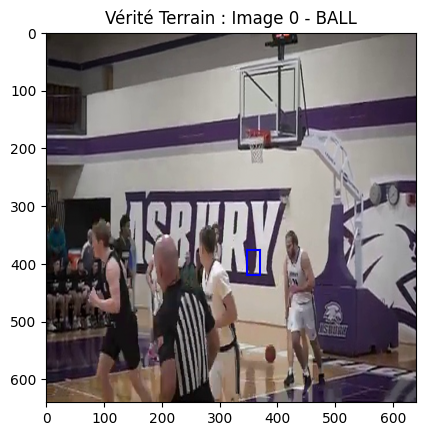

Box raw values: [0.45447664 0.29844291 0.03308824 0.05709343]
Dénormalisées: 391.4124050405442 372.8669260741167 22.47752446060259 42.16104090506999


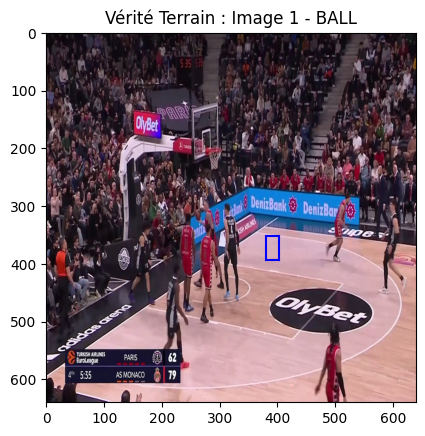

Box raw values: [0.30217344 0.46799308 0.03211505 0.05709343]
Dénormalisées: 368.6315765677069 390.4286353777226 22.468237826086664 42.16104090506999


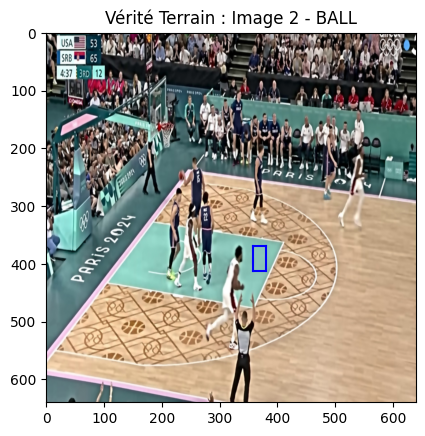

Box raw values: [0.12943339 0.46193772 0.0291955  0.05536332]
Dénormalisées: 342.79389571193303 389.8014314740225 22.440377922538882 42.133165021985675


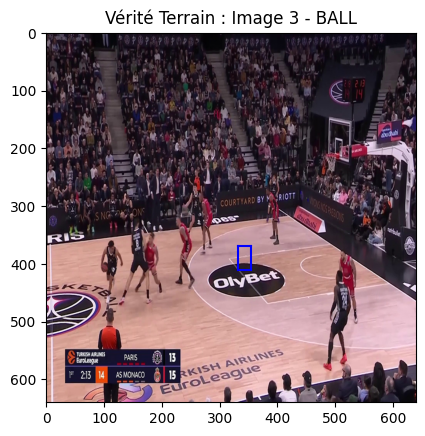

Box raw values: [0.70263841 0.69463668 0.02530277 0.0432526 ]
Dénormalisées: 428.53132683334604 413.9039814876449 22.40323138447518 41.93803384039551


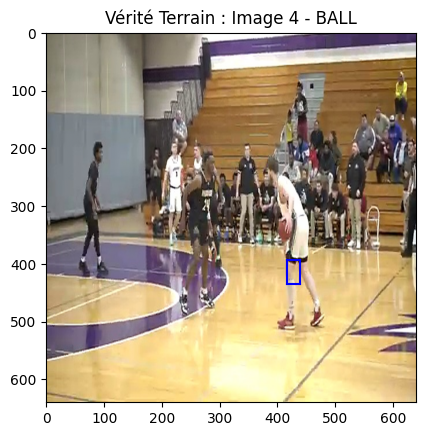

Box raw values: [0.29633434 0.22491349 0.02822232 0.05190311]
Dénormalisées: 367.75819017258215 365.25087867204263 22.43109128802296 42.07741325581706


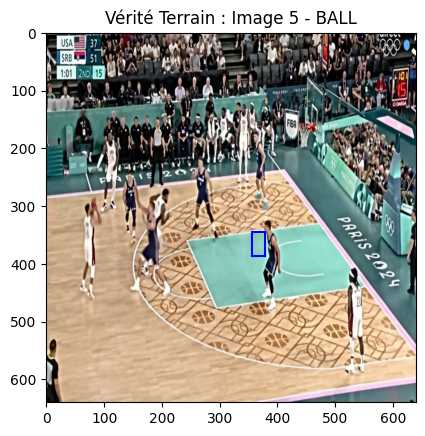

Box raw values: [0.73669983 0.42647059 0.0408737  0.05709343]
Dénormalisées: 433.626080804907 386.1278086094926 22.55181753673 42.16104090506999


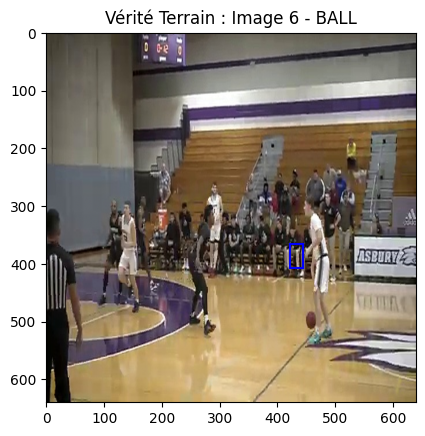

Box raw values: [0.12554066 0.46107266 0.02530277 0.05363322]
Dénormalisées: 342.21163811518323 389.711830916351 22.40323138447518 42.10528913890137


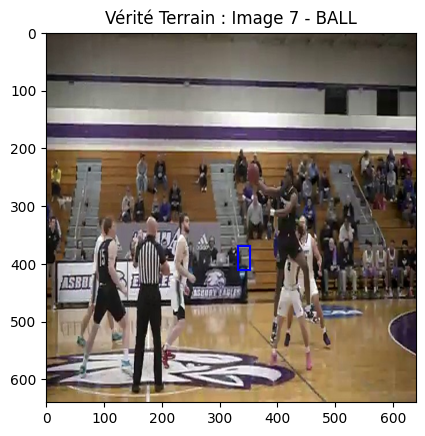

Box raw values: [0.71723616 0.77422145 0.04476644 0.09515571]
Dénormalisées: 430.71479282115786 422.14723279341916 22.5889640747937 42.77431033292483


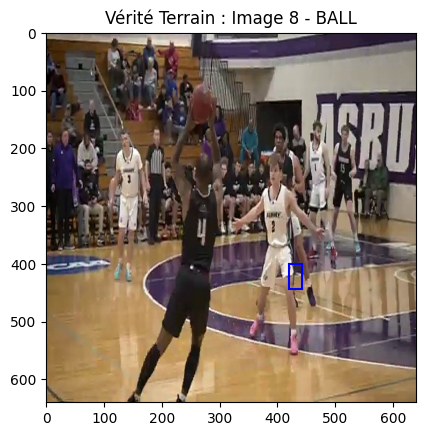

Box raw values: [0.65349265 0.68858131 0.03990052 0.06574394]
Dénormalisées: 421.18032467437945 413.27677758394475 22.542530902214075 42.30042032049155


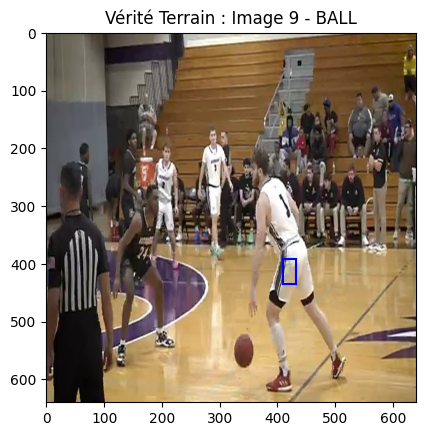

In [51]:
# Si seuls x et y sont indiqués, on tire au hasard un numéro d'image et on affiche le label y associé  à l'image
# Si un 2e y, nommé y_pred, est indiqué, alors les deux labels sont affichés côte à côte, afin de pouvoir les comparer
# Enfin on peut également indiquer l'id de l'image que l'on souhaite visualiser.
def print_data_localisation(x, y, y_pred=[], id=None, image_size=640):
  if id==None:
    # Tirage aléatoire d'une image dans la base
    num_img = np.random.randint(x.shape[0]-1)
  else:
    num_img = id


  img = x[num_img]
  lab = y[num_img]

  colors = ["blue"] # Différentes couleurs pour les différentes classes
  classes = ['BALL']

  if np.any(y_pred):
    plt.subplot(1, 2, 1)

  # Affichage de l'image
  plt.imshow(img)
  # Détermination de la classe
  class_id = np.argmax(lab[5:])

  # Détermination des coordonnées de la boîte englobante dans le repère image
  ax = (lab[1]*y_std[1] + y_mean[1]) * image_size
  ay = (lab[2]*y_std[2] + y_mean[2]) * image_size
  width = (lab[3]*y_std[3] + y_mean[3]) * image_size
  height = (lab[4]*y_std[4] + y_mean[4]) * image_size
  print("Box raw values:", lab[1:5])
  print("Dénormalisées:", ax, ay, width, height)
  #print("x: {}, y: {}, w: {}, h:{}".format(ax,ay,width, height))
  # Détermination des extrema de la boîte englobante
  p_x = [ax-width/2, ax+width/2]
  p_y = [ay-height/2, ay+height/2]
  # Affichage de la boîte englobante, dans la bonne couleur
  plt.plot([p_x[0], p_x[0]],p_y,color=colors[class_id])
  plt.plot([p_x[1], p_x[1]],p_y,color=colors[class_id])
  plt.plot(p_x,[p_y[0],p_y[0]],color=colors[class_id])
  plt.plot(p_x,[p_y[1],p_y[1]],color=colors[class_id])
  plt.title("Vérité Terrain : Image {} - {}".format(num_img, classes[class_id]))

  if np.any(y_pred):
    plt.subplot(1, 2, 2)
    # Affichage de l'image
    plt.imshow(img)
    lab = y_pred[num_img]
    # Détermination de la classe
    class_id = np.argmax(lab[5:])

    # Détermination des coordonnées de la boîte englobante dans le repère image
    ax = (lab[1]*y_std[1] + y_mean[1]) * image_size
    ay = (lab[2]*y_std[2] + y_mean[2]) * image_size
    width = (lab[3]*y_std[3] + y_mean[3]) * image_size
    height = (lab[4]*y_std[4] + y_mean[4]) * image_size
    #print("x: {}, y: {}, w: {}, h:{}".format(ax,ay,width, height))
    # Détermination des extrema de la boîte englobante
    p_x = [ax-width/2, ax+width/2]
    p_y = [ay-height/2, ay+height/2]
    # Affichage de la boîte englobante, dans la bonne couleur
    plt.plot([p_x[0], p_x[0]],p_y,color=colors[class_id])
    plt.plot([p_x[1], p_x[1]],p_y,color=colors[class_id])
    plt.plot(p_x,[p_y[0],p_y[0]],color=colors[class_id])
    plt.plot(p_x,[p_y[1],p_y[1]],color=colors[class_id])
    plt.title("Prédiction : Image {} - {}".format(num_img, classes[class_id]))

  plt.show()

for i in range(10):#x.shape[0]):
    print_data_localisation(x_train, y_train, image_size=IMAGE_SIZE, id=i)
